# The Limitation using POLARIS 
This experiment focuses on the limitations of POLARIS that we identified. The primary limitation is that the location of inputs significantly affects the final results. We aim to demonstrate this limitation by comparing two synthetic datasets from the Hsp90 molecule. The only difference between these two datasets is that we have altered the rotation of conformational changes: from 1 and 2 to 0.5 and 1.44, respectively.

We provided the same occupancy map for cloning the volumes, meaning we wanted to search for the same transition sequence in these two datasets. However, when using POLARIS, the dataset with a minor rotation was identified correctly. We believe this limitation arises from the location of inputs and the main transition group. In this scenario, the starting state, transition state, and ending state form a triangle. If the longest edge of this triangle is shorter than the sum of the two shorter edges, the algorithm searches along the long edge. This is because there's no significant improvement in taking the longer path.

**We used the default parameters and activated the transition weighting option in all our experiments.**

In [1]:
import numpy as np 
import pandas as pd
import os 
from scipy.spatial import distance
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

# Use cryodrgn env
from cryodrgn import utils
from cryodrgn import analysis
from cryodrgn import fft, mrc

import umap

In [2]:
def get_nearest_point(data, query):
    '''
    Find closest point in @data to @query
    Return index 
    '''
    ind = cdist(query, data).argmin(axis=1)
    return ind

def free_energy(emb, n_states):
    '''
    Convert to energy landscape based on bins-count appraoch.
    '''
    grids, _ = np.histogramdd(emb, bins=(n_states+1, n_states+1)) # n+1 bins to cut n cells
    grids = grids.T
    # Energy
    occmax = np.amax(grids)
    E = -np.log(grids/occmax)
    E[E==np.inf] = np.unique(E)[-2] + 0.00001 # replace -inf to second lowest energy plus constant.
    return E

def points_for_polaris(emb, n_states, list_idx):
    '''
    Convert the starting and ending point index in to the location in 2D energy landscape.
    '''
    x = emb[:,0][list_idx]
    y = emb[:,1][list_idx]
    n_cells_x = np.linspace(emb[:,0].min(), emb[:,0].max(), n_states+1)
    n_cells_y = np.linspace(emb[:,1].min(), emb[:,1].max(), n_states+1)
    x = np.digitize(x, n_cells_x) -1
    y = np.digitize(y, n_cells_y) -1
    return np.stack((x,y), axis=1)

def convert_polaris_result(emb, path, n_states=60):
    ''' 
    After searching MEP using POLARIS, convert the path location in 2D back to data point index
    '''
    # Create the bin edges
    n_cells_x = np.linspace(emb[:,0].min(), emb[:,0].max(), n_states + 1)
    n_cells_y = np.linspace(emb[:,1].min(), emb[:,1].max(), n_states + 1)
    # Calculate the center of each bin
    centers_x = (n_cells_x[:-1] + n_cells_x[1:]) / 2
    centers_y = (n_cells_y[:-1] + n_cells_y[1:]) / 2
    # energy coordiante -> embedding space coordinate
    emb_x = centers_x[path[:, 0].astype(int)]
    emb_y = centers_y[path[:, 1].astype(int)]
    polaris_2d = np.stack((emb_x, emb_y), axis=1)
    # embedding space coordinate -> nearest point index 
    polaris_path = get_nearest_point(emb, polaris_2d)
    return polaris_path

In [3]:
##### MOTIFY THIS PART WHILE DOING OTHER EXPERIMENTS #####
def cal_state_label(x, y):
    '''calculate ground truth labels'''
    label = 20*(x-1)+y
    return label

def get_ground_truth_labels(occ, n_PDs):
    '''
    Calculate ground truth label for each center.
    Since when we create MRC clones are use the order of occ[i][j], 
    the ground truth label would start at CM2 firest. 
    e.g. state_01_01 -> state_01_02 -> ... -> state_05_05 clone 5 times -> ...
    And each MRC would have N PDs images 
    '''
    n_confs = occ.shape[0]**2 # 20x20 CMs in hsp90 experiment
    occ_list = occ.T.flatten().astype(int) # equivalent to occ[i][j]
    ground_truth_labels = np.repeat(np.repeat(np.arange(1,n_confs+1), occ_list), n_PDs)
    return ground_truth_labels

def get_centers_and_path(z, ground_truth_labels):
    '''
    In hsp90 experiment, state1:(5,5), state2(15,16), transition:(15,5)
    '''
    state1 = ground_truth_labels==cal_state_label(5,5)
    state2 = ground_truth_labels==cal_state_label(15,16)
    transition_state = ground_truth_labels==cal_state_label(15,5)

    center1 = get_nearest_point(z, [np.mean(z[state1], axis=0)])[0]
    center2 = get_nearest_point(z, [np.mean(z[state2], axis=0)])[0]
    transition = get_nearest_point(z, [np.mean(z[transition_state], axis=0)])[0]

    path1_label = cal_state_label(np.arange(5,16), 5)
    path1 = []
    for i in path1_label:
        path1.append(get_nearest_point(z, [np.mean(z[ground_truth_labels==i], axis=0)])[0])
    path2_label = cal_state_label(15, np.arange(5,16+1))
    path2 = []
    for i in path2_label:
        path2.append(get_nearest_point(z, [np.mean(z[ground_truth_labels==i], axis=0)])[0])
    truth_path = path1 + path2

    return state1, state2, transition_state, center1, center2, transition, truth_path
#######################################################

In [4]:
workdir = "/mnt/d/energy_aware_pathfinding/supplementary/polaris_limitation"

# load ground trouth occupancy map
occ = np.load("/mnt/d/energy_aware_pathfinding/hsp90/noise_occ_1120.npy")
# load the original latent space
z = utils.load_pkl("/mnt/d/energy_aware_pathfinding/hsp90/z_8/z.49.pkl")
# load the latent space of minor rotation dataset
z_minor = utils.load_pkl(f"{workdir}/hsp90_minor/z_8/z.49.pkl")

# get lables
n_PDs = 50
ground_truth_label = get_ground_truth_labels(occ, n_PDs)
state1, state2, transition_state, center1, center2, transition, truth_path = get_centers_and_path(z, ground_truth_label)
state1_minor, state2_minor, transition_state_minor, center1_minor, center2_minor, transition_minor, truth_path_minor = get_centers_and_path(z_minor, ground_truth_label)

In [69]:
dens_emb_minor = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    learning_rate=1e-3,
    densmap=True,
    dens_frac=0.7,
    dens_lambda=3,
    random_state=915
).fit_transform(z_minor)

np.save(f'{workdir}/dens_emb_minor.npy', dens_emb_minor)

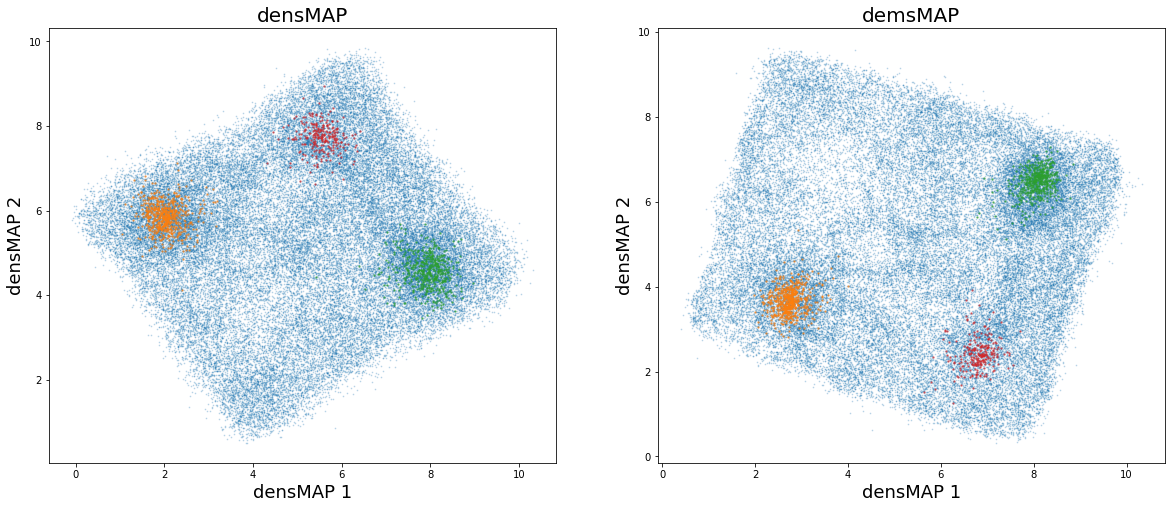

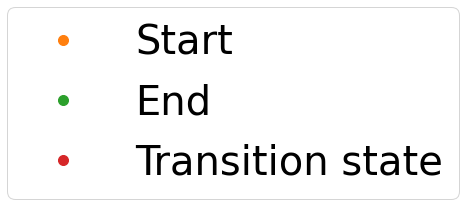

In [22]:
dens_emb = np.load("/mnt/d/energy_aware_pathfinding/hsp90/dens_emb.npy")
dens_emb_minor = np.load(f"{workdir}/dens_emb_minor.npy")
state_legend = ["Start", "End", "Transition state"]
state_colors = ['tab:orange', 'tab:green', 'tab:red']


fig, axs = plt.subplots(1, 2, figsize=(20, 8))
# minor 
axs[0].scatter(dens_emb_minor[:, 0], dens_emb_minor[:, 1], s=0.5, alpha=0.25)  
for i, state in enumerate([state1_minor, state2_minor, transition_state_minor]):
    axs[0].scatter(dens_emb_minor[state][:, 0], dens_emb_minor[state][:, 1], s=2, alpha=0.5, c=state_colors[i], zorder=1)
axs[0].set_title('densMAP', fontsize=20)
axs[0].set_xlabel('densMAP 1', fontsize=18)
axs[0].set_ylabel('densMAP 2', fontsize=18)
# original
axs[1].scatter(dens_emb[:, 0], dens_emb[:, 1], s=0.5, alpha=0.25)  
for i, state in enumerate([state1, state2, transition_state]):
    axs[1].scatter(dens_emb[state][:, 0], dens_emb[state][:, 1], s=2, alpha=0.5, c=state_colors[i], zorder=1)  
axs[1].set_title('demsMAP', fontsize=20)
axs[1].set_xlabel('densMAP 1', fontsize=18)
axs[1].set_ylabel('densMAP 2', fontsize=18)
plt.show()

# legend plot
fig_legend = plt.figure(figsize=(2, 1))  
axi = fig_legend.add_subplot(111)
axi.axis('off')
lines_states = [plt.Line2D([0], [0], color=c, marker='o', linestyle='', markersize=10) for c in state_colors]
fig_legend.legend(lines_states, state_legend, fontsize=40, loc='center')
plt.show()

In [7]:
minor_eng = free_energy(dens_emb_minor, n_states=60)
original_eng = free_energy(dens_emb, n_states=60)
np.savetxt('/home/danlin/POLARIS/data_input/hsp90_minor.txt', minor_eng)

print("minor")
pol_input_minor = points_for_polaris(dens_emb_minor, n_states=60, list_idx=[center1_minor, transition_minor, center2_minor])
print(f'Start:{pol_input_minor[0,:]}, End:{pol_input_minor[2,:]}')
print("original")
pol_input_original = points_for_polaris(dens_emb, n_states=60, list_idx=[center1, transition, center2])
print(f'Start:{pol_input_original[0,:]}, End:{pol_input_original[2,:]}')

minor
Start:[11 32], End:[47 26]
original
Start:[14 21], End:[46 40]


<ipython-input-2-a838f5ed2030>:17: RuntimeWarning: divide by zero encountered in log
  E = -np.log(grids/occmax)


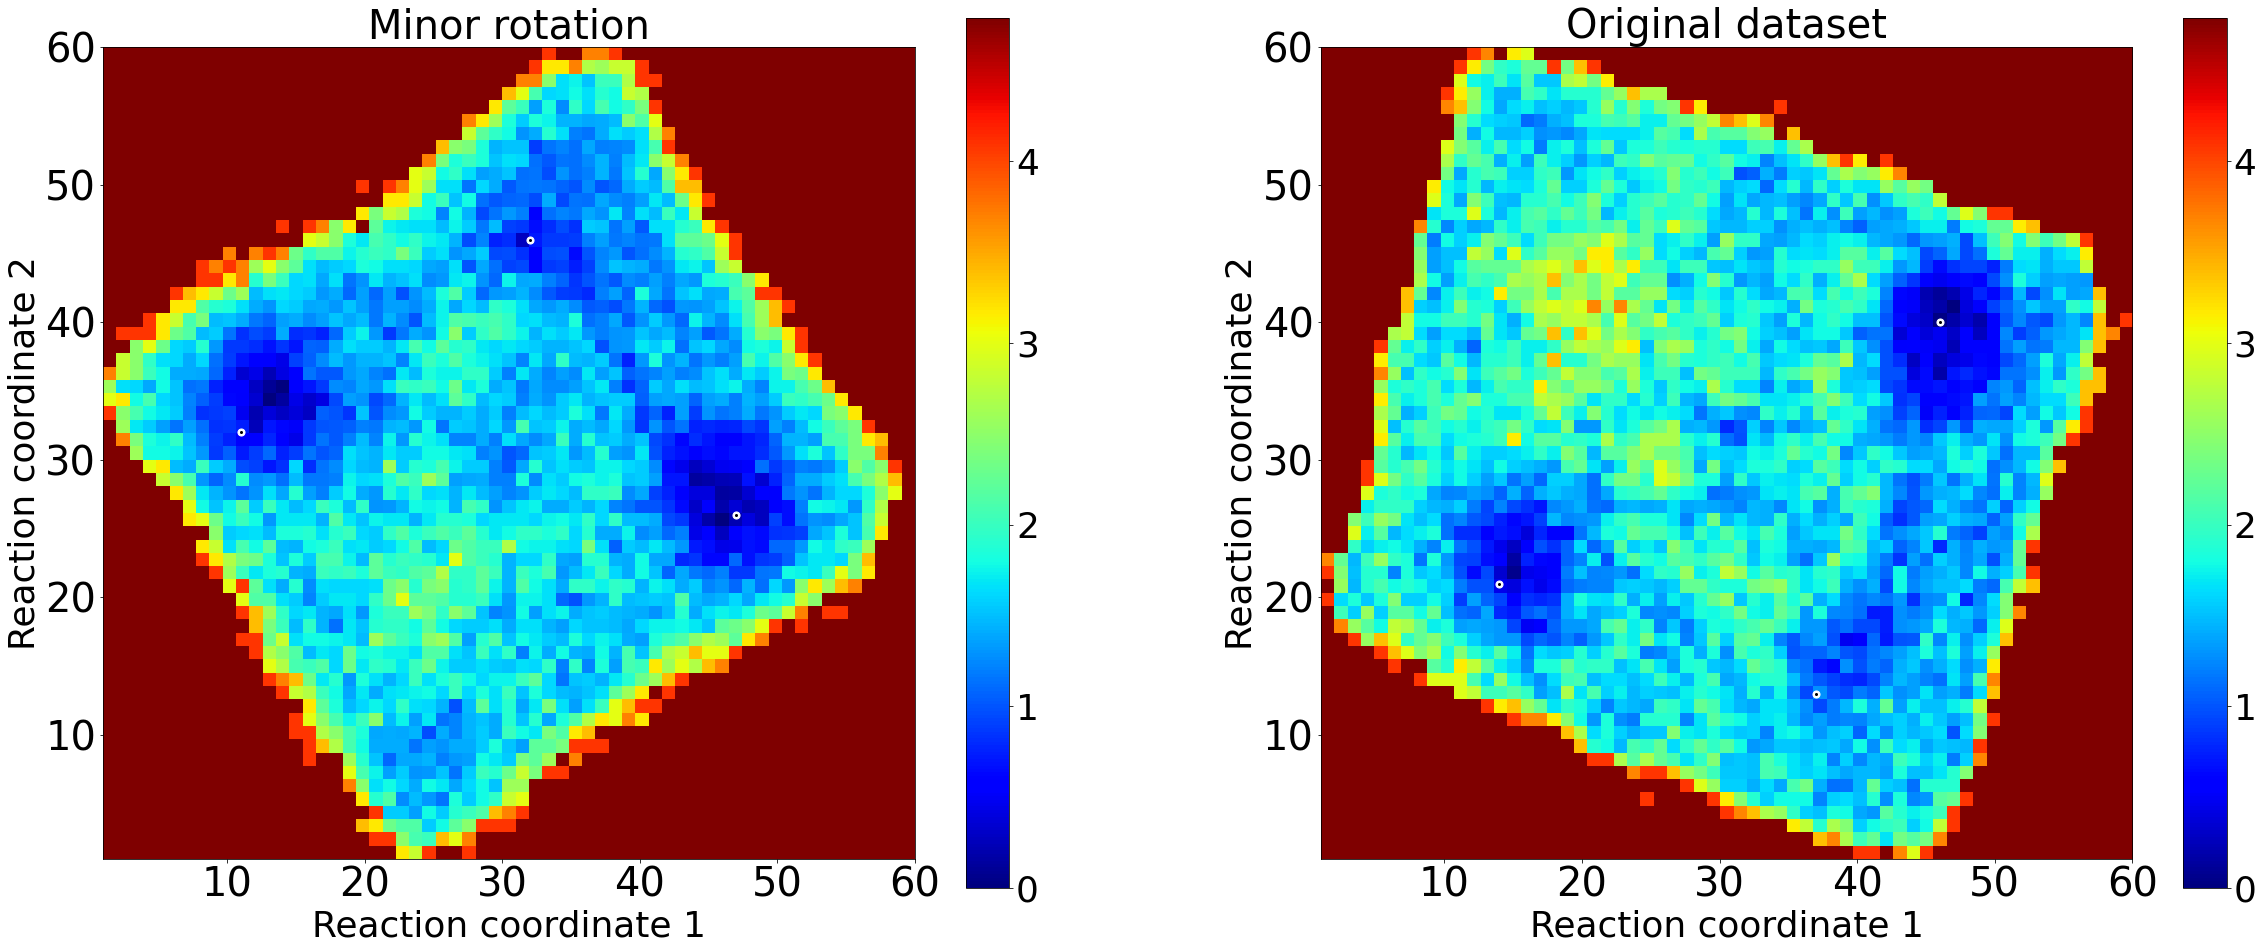

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(40, 16))
# minor
im0 = axs[0].imshow(minor_eng, origin='lower', extent=[1,60,1,60], cmap='jet')
axs[0].scatter(pol_input_minor[:,0], pol_input_minor[:,1], c='white', s=50)
axs[0].scatter(pol_input_minor[:,0], pol_input_minor[:,1], c='k', s=4)
cbar = fig.colorbar(im0, ax=axs[0])
cbar.ax.set_yticks([0,1,2,3,4])
cbar.ax.set_yticklabels(['0', '1', '2', '3', '4'], fontsize=36)
axs[0].tick_params(axis='both', which='major', labelsize=40)
axs[0].set_title('Minor rotation', fontsize=40)
axs[0].set_xlabel('Reaction coordinate 1', fontsize=36)
axs[0].set_ylabel('Reaction coordinate 2', fontsize=36)
# original
im1 = axs[1].imshow(original_eng, origin='lower', extent=[1,60,1,60], cmap='jet')
axs[1].scatter(pol_input_original[:,0], pol_input_original[:,1], c='white', s=50)
axs[1].scatter(pol_input_original[:,0], pol_input_original[:,1], c='k', s=4)
cbar = fig.colorbar(im0, ax=axs[1])
cbar.ax.set_yticks([0,1,2,3,4])
cbar.ax.set_yticklabels(['0', '1', '2', '3', '4'], fontsize=36)
axs[1].tick_params(axis='both', which='major', labelsize=40)
axs[1].set_title('Original dataset', fontsize=40)
axs[1].set_xlabel('Reaction coordinate 1', fontsize=36)
axs[1].set_ylabel('Reaction coordinate 2', fontsize=36)

plt.show()

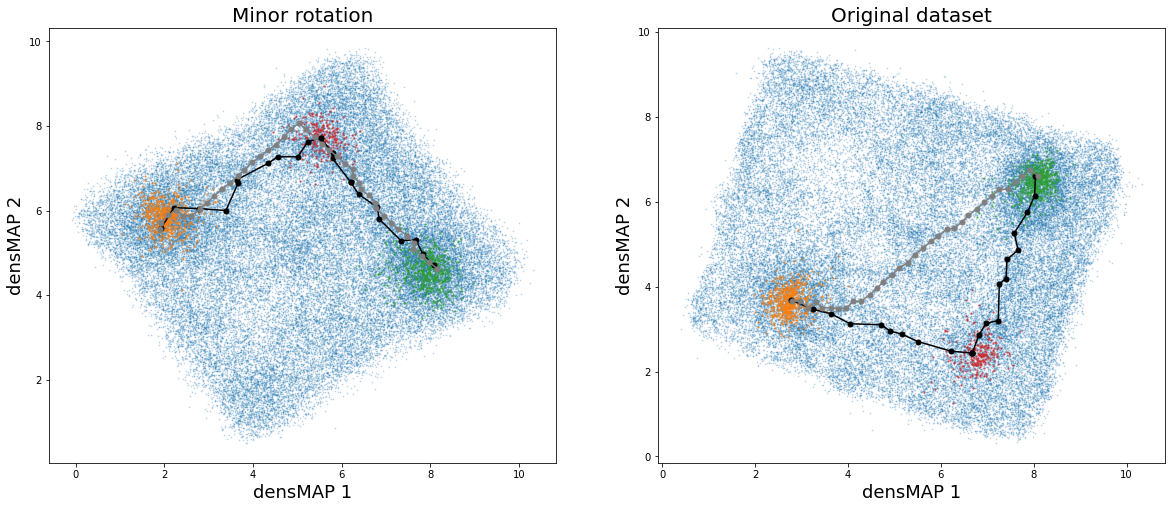

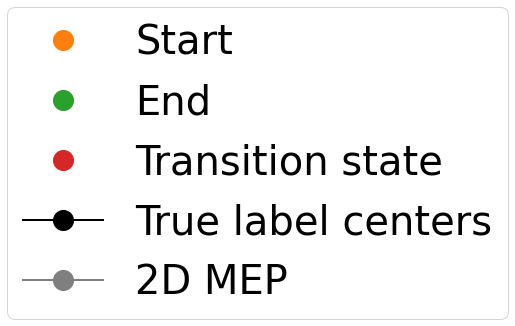

In [25]:
minor_result = np.loadtxt(f'{workdir}/polaris_minor/polaris_minor.txt', skiprows=9, usecols=(0, 1)) 
minor_result = convert_polaris_result(emb=dens_emb_minor, path=minor_result).astype(int)
original_result = np.loadtxt('/mnt/d/energy_aware_pathfinding/hsp90/polaris/polaris_output.txt', skiprows=9, usecols=(0, 1)) #only keep x and y coodrinate
original_result = convert_polaris_result(emb=dens_emb, path=original_result).astype(int)

state_legend = ["Start", "End", "Transition state"]
state_colors = ['tab:orange', 'tab:green', 'tab:red']
path_legend = ["True label centers", 
            "2D MEP"]
path_colors= ['k', 'tab:gray']


fig, axs = plt.subplots(1, 2, figsize=(20, 8))
# minor
axs[0].scatter(dens_emb_minor[:, 0], dens_emb_minor[:, 1], s=0.5, alpha=0.25)  
for i, state in enumerate([state1_minor, state2_minor, transition_state_minor]):
    axs[0].scatter(dens_emb_minor[state][:, 0], dens_emb_minor[state][:, 1], s=2, alpha=0.5, c=state_colors[i], zorder=1)
for i, path in enumerate([truth_path_minor, minor_result]):
    axs[0].plot(
        dens_emb_minor[path][:, 0], dens_emb_minor[path][:, 1], '-o',
        markersize=5, c=path_colors[i], zorder=2
    ) #paths
axs[0].set_title('Minor rotation', fontsize=20)
axs[0].set_xlabel('densMAP 1', fontsize=18)
axs[0].set_ylabel('densMAP 2', fontsize=18)
# original
axs[1].scatter(dens_emb[:, 0], dens_emb[:, 1], s=0.5, alpha=0.25)  
for i, state in enumerate([state1, state2, transition_state]):
    axs[1].scatter(dens_emb[state][:, 0], dens_emb[state][:, 1], s=2, alpha=0.5, c=state_colors[i], zorder=1)
for i, path in enumerate([truth_path, original_result]):
    axs[1].plot(
        dens_emb[path][:, 0], dens_emb[path][:, 1], '-o',
        markersize=5, c=path_colors[i], zorder=2
    ) #paths
axs[1].set_title('Original dataset', fontsize=20)
axs[1].set_xlabel('densMAP 1', fontsize=18)
axs[1].set_ylabel('densMAP 2', fontsize=18)
plt.show()

# legend plot
fig_legend_combined = plt.figure(figsize=(5, 3))  
axi = fig_legend_combined.add_subplot(111)
axi.axis('off')
lines_states = [plt.Line2D([0], [0], color=c, marker='o', linestyle='', markersize=20) for c in state_colors]
lines_paths = [plt.Line2D([0], [0], color=c, linewidth=2, marker='o', markersize=20) for c in path_colors] 
combined_lines = lines_states + lines_paths
combined_labels = state_legend + path_legend
fig_legend_combined.legend(combined_lines, combined_labels, fontsize=40, loc='center')
plt.show()

In [13]:
def closest_to_transition(z, path, transition_idx):
    '''
    Find the point in the path which is closest to the transtion state center
    '''
    nearest_point = None
    nearest_distance = float('inf')
    for indx, points in enumerate(z[path]):
        d = distance.euclidean(z[transition_idx], points)
        if d < nearest_distance:
            nearest_point = indx
            nearest_distance = d
    return path[nearest_point], nearest_distance

def ave_distance(z, truth, path):
    dis = []
    for i in truth:
        _, d = closest_to_transition(z, path, i)
        dis.append(d)
    return sum(dis)/(len(truth)-2)
    
def sum_distance(z, truth, path):
    dis = []
    for i in truth:
        _, d = closest_to_transition(z, path, i)
        dis.append(d)
    return sum(dis)

def hausdorff_distance(set1, set2):
  # Initialize maximum distance to 0
  max_distance_1 = 0
  
  # Iterate through points in set1
  for point1 in set1:
    # Find nearest point in set2
    nearest_point = None
    nearest_distance = float('inf')
    for point2 in set2:
      d = distance.euclidean(point1, point2)
      if d < nearest_distance:
        nearest_point = point2
        nearest_distance = d
    # Update maximum distance if necessary
    max_distance_1 = max(max_distance_1, nearest_distance)
  
  max_distance_2 = 0

  for point2 in set2:
    nearest_point = None
    nearest_distance = float('inf')

    for point1 in set1:
      d = distance.euclidean(point1, point2)
      if d < nearest_distance:
        nearest_point = point1
        nearest_distance = d
    
    max_distance_2 = max(max_distance_2, nearest_distance)

  max_distance = max(max_distance_1, max_distance_2)
  return max_distance

In [14]:
print("Minor:", ave_distance(z_minor, truth_path_minor, minor_result))
print("Original:", ave_distance(z, truth_path, original_result))

Minor: 1.1190037060351599
Original: 1.9569273193677266


In [16]:
print("Minor:", hausdorff_distance(z_minor[truth_path_minor], z[minor_result]))
print("Original:", hausdorff_distance(z[truth_path], z[original_result]))

Minor: 5.376283168792725
Original: 3.1935112476348877


# Comparsion

In [17]:
print("Minor: Long edge")
print(distance.euclidean(pol_input_minor[0], pol_input_minor[1]))
print("Minor: Sum of two edges")
print(distance.euclidean(pol_input_minor[0], pol_input_minor[2])+distance.euclidean(pol_input_minor[2], pol_input_minor[1]))

print("Original: Long edge")
print(distance.euclidean(pol_input_original[0], pol_input_original[1]))
print("Original: Sum of two edges")
print(distance.euclidean(pol_input_original[0], pol_input_original[2])+distance.euclidean(pol_input_original[2], pol_input_original[1]))

Minor: Long edge
25.238858928247925
Minor: Sum of two edges
61.49657518178932
Original: Long edge
24.351591323771842
Original: Sum of two edges
65.6760870733722
